# The Marine Navigation problem (Julia code)
### by P. Negre and M. Sadak ([Polytech Nice Sophia, Applied math. dep](http://www.polytech-nice-sophia.fr/formation/ingenieur-mathematiques-appliquees-et-modelisation))

We consider a ship moving in a portion of ocean undergoing a constant current (the whole fluid has constant horizontal velocity $w$) and towing a spread.
The towed streamer is made of $N$ segments of length $\ell$. After some normalisations, the system can be written as follows (see [this paper](http://caillau.perso.math.cnrs.fr/research/cdc-2019b.pdf) for a detailed description of the $N=1$ case):

$$
\left \lbrace
\begin{array}{l}
\dot x = w+\cos\theta,\\
\dot y = \sin\theta,\\
\dot\theta = u,\\
\dot\beta_k = -u-\frac 1l(\prod_{j=1}^{k-1}\cos(\beta_j -\beta_{j-1}))\sin(\beta_k - \beta_{k-1}),\\
\beta_k = \theta_k - \theta, \ \theta_0 = \theta,\\
|u| \le 1, \ 0\le w < 1, \ 0<l<1
\end{array}
\right.
$$

where $\alpha_k:=\theta_k-\theta_{k-1}$ (and $\theta_0:=\theta$). The minimum time problem is considered.

![Thumbnail](thumbnail.png)

[Thumbnail](thumbnail.png)

In [25]:
using JuMP,Plots,Ipopt

Solving...


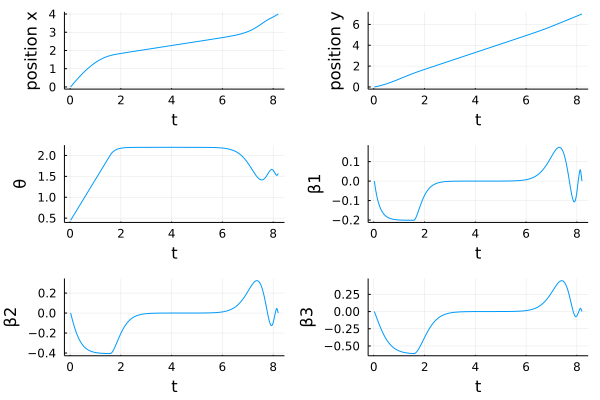

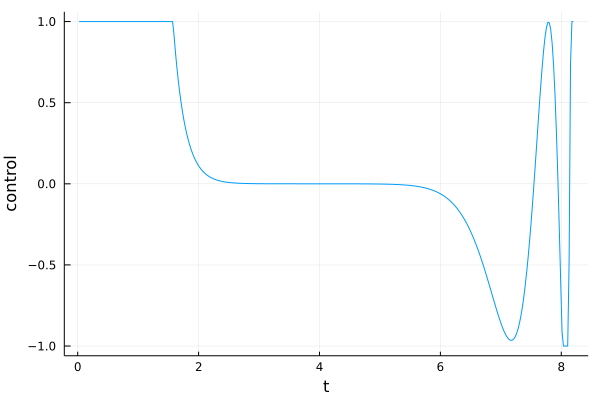

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    14322
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    39088

Total number of variables............................:     2801
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      351
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2456
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

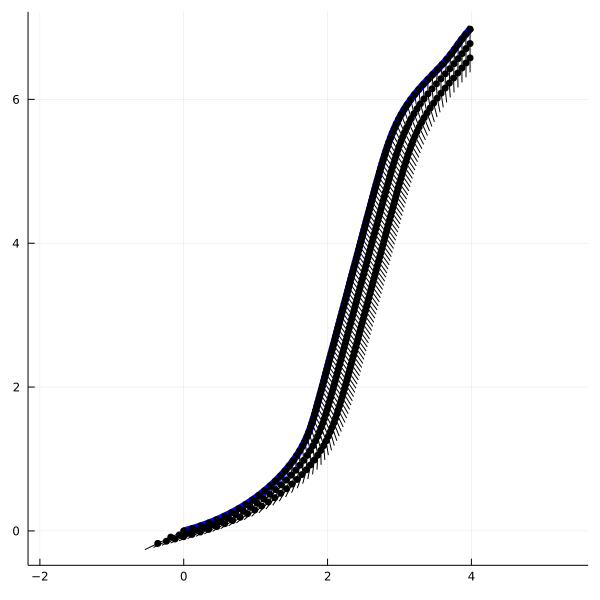

In [26]:
#JuMP model, Ipopt solver
sys = Model(optimizer_with_attributes(Ipopt.Optimizer,"print_level"=> 5))
set_optimizer_attribute(sys,"tol",1e-14)
set_optimizer_attribute(sys,"max_iter",1000)

#Parameters

# constants
w = 0.8
l = 0.2
epsi = 1e-4

# initial data
x0 = 0 
y0 = 0 
θ0 = pi/7
β1_0 = 0 
β2_0 = 0
β3_0 = 0 
c0 = 0

# final data
xf = 4
yf = 7
θf = pi/2 
β1_f = 0
β2_f = 0
β3_f = 0

N = 350
# Bounds for variables

JuMP.@variables(sys,begin
    x[1:N]           # x 
    y[1:N]           # y 
    θ[1:N]           # theta
    β1[1:N]          # beta1 
    β2[1:N]          # beta2
    β3[1:N]          # beta3
    -1 ≤ u[1:N] ≤ 1  # u, control
     0 ≤ Δt ≤ 1 
    c[1:N]
    end)

# Objective
@objective(sys,Min,Δt+epsi*c[N])

# Constraints 

@constraints(sys,begin
    x[1] == x0
    y[1] == y0
    θ[1] == θ0
    β1[1]== β1_0
    β2[1] == β2_0
    β3[1] == β3_0 
    c[1] == c0
    x[N] == xf
    y[N] == yf
    θ[N] == θf
    β1[N] == β1_f
    β2[N] == β2_f
    β3[N] == β3_f
        end)

# Dynamics : Crank-Nicolson scheme

for j in 1 : N-1
    @NLconstraint(sys, # x' = w + cos(theta)
        x[j+1] == x[j] + 0.5 * Δt * (w + cos(θ[j]) + w + cos(θ[j+1])))
    @NLconstraint(sys, # y' = sin(theta) 
        y[j+1] == y[j] + 0.5* Δt *(sin(θ[j])+ sin(θ[j+1])))
    @NLconstraint(sys, #beta1 ' = -u- 1/l * sin(beta1)
        β1[j+1] == β1[j] + 0.5 * Δt * (-u[j]-(1/l)*sin(β1[j]) - u[j+1] - (1/l)*sin(β1[j+1])))
    @NLconstraint(sys, #beta2' = -u - cos(beta1)*sin(beta2 - beta1)/l
        β2[j+1] == β2[j] + 0.5 *  Δt * (-u[j] - cos(β1[j])*sin(β2[j] - β1[j])/l - u[j+1] - cos(β1[j+1])*sin(β2[j+1] - β1[j+1])/l ))
    @NLconstraint(sys, #beta3' = -u - cos(beta1) * cos(beta2-beta1)*sin(beta3 - beta2)
        β3[j+1] == β3[j] +0.5  * Δt * (-u[j] - cos(β1[j])*cos(β2[j] - β1[j]) * sin(β3[j] - β2[j])/l -u[j+1] - cos(β1[j+1])*cos(β2[j+1] - β1[j+1]) * sin(β3[j+1] - β2[j+1])/l ))
    @NLconstraint(sys, # L2-norm regularization on the control
        c[j+1] == c[j] + 0.5 * Δt * (u[j]^2+ u[j+1]^2))
end

@NLconstraint(sys,p_t[j = 1:(N-1)],  # theta ' = u 
        θ[j+1] == θ[j] + 0.5 * Δt * (u[j] + u[j+1]) )


#Solve for the control and state
println("Solving...")
status = optimize!(sys)
println("Solver status : ",status)
x1 = value.(x)
y1 = value.(y)
θ1 = value.(θ)
β_1 = value.(β1)
β_2 = value.(β2)
β_3 = value.(β3)
u1 = value.(u)
println("Cost : " , objective_value(sys))

println("tf = ", value.(Δt)*N)


#plots : states 

Δt1 = value.(Δt)
t = (1 : N)*Δt1
#h = (1 : N)

x_plot = plot(t,x1,xlabel = "t", ylabel = "position x", legend = false, fmt = :png)
y_plot = plot(t,y1,xlabel = "t", ylabel = "position y", legend = false, fmt = :png)
θ_plot = plot(t,θ1,xlabel = "t", ylabel = "θ", legend = false, fmt = :png)
β1_plot = plot(t,β_1,xlabel = "t", ylabel = "β1", legend = false, fmt = :png)
β2_plot = plot(t,β_2,xlabel = "t", ylabel = "β2", legend = false, fmt = :png)
β3_plot = plot(t,β_3,xlabel = "t", ylabel = "β3", legend = false, fmt = :png)
display(plot(x_plot,y_plot,θ_plot,β1_plot,β2_plot,β3_plot ,layout = (3,2)))
u_plot = plot(t,u1,xlabel = "t", ylabel = "control", legend = false, fmt = :png)
display(u_plot)


#plots : trajectory 
p = plot(x1,y1, c = :blue, lw = 7)
plot!(size=(2000,2000))

dN = 3 # step for trajectory plot
for i = 1:dN:N 
    z = [x1[i] y1[i]]
    θ_p = θ1[i]
    β1_p = β_1[i]
    β2_p = β_2[i]
    β3_p = β_3[i]
    θ_1 =  β1_p + θ_p
    θ_2 =  β2_p + θ_p
    θ_3 =  β3_p + θ_p
    z1 = z - l*[cos(θ_1) sin(θ_1)]
    z2 = z1 - l*[cos(θ_2) sin(θ_2)]
    z3 = z2 - l*[cos(θ_3) sin(θ_3)]
    plot!([z[1],z1[1]], [z[2],z1[2]] ,color=:black, legend = false)
    plot!([z1[1],z2[1]], [z1[2],z2[2]], color=:black, legend = false)
    plot!([z2[1],z3[1]], [z2[2],z3[2]], color=:black, legend = false)
    plot!([z[1]],[z[2]],seriestype = :scatter, color =:black , legend = false)
    plot!([z1[1]],[z1[2]],seriestype = :scatter, color =:black , legend = false) 
    plot!([z2[1]],[z2[2]],seriestype = :scatter, color =:black , legend = false) 
    plot!(size=(600,600), aspect_ratio=:equal)
end
current()

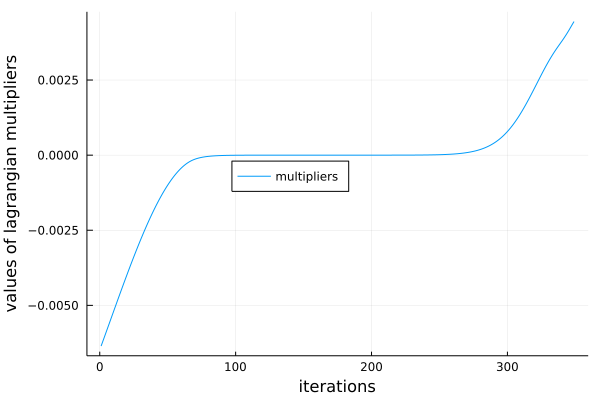

has_dual ? : true


In [27]:
#Lagrangian multipliers

print("has_dual ? : " , has_duals(sys))
print("\n")
storage = zeros(N-1)
for i in 1 : N-1
    storage[i] = dual(p_t[i])
end

lagrangian_multipliers = plot(storage,fmt=:png,xlabel = "iterations", ylabel = "values of lagrangian multipliers",legend = :inside, label = "multipliers")
display(plot(lagrangian_multipliers,layout=(1,1)))

Solving...
This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    14322
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    39088

Total number of variables............................:     2801
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      351
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2456
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr

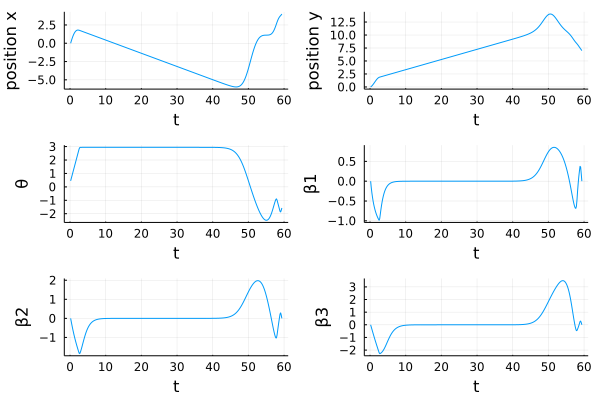

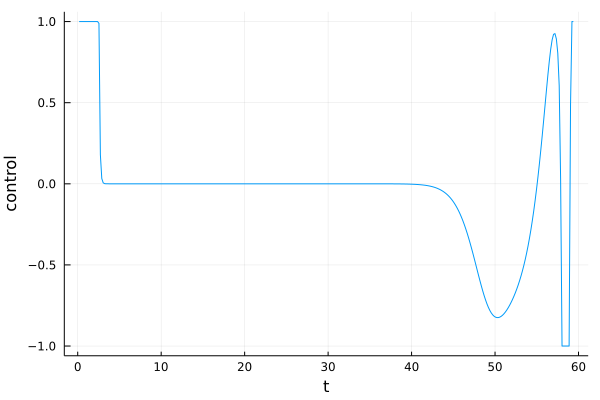


Cost : 0.1704991543147269
tf = 59.383676896955365


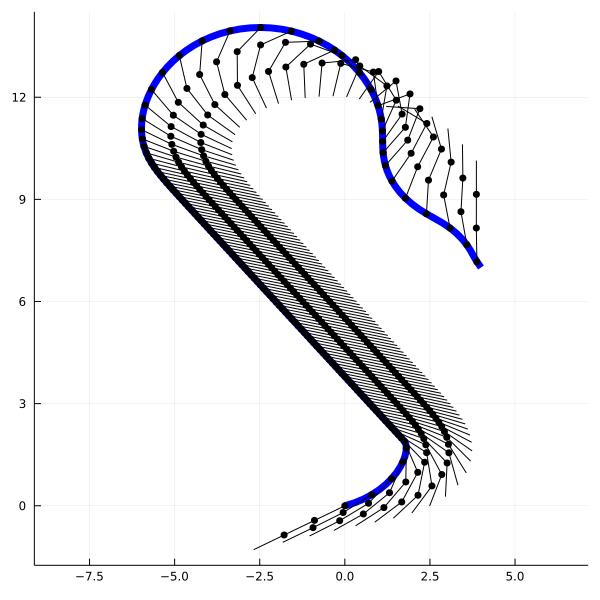

In [28]:
#JuMP model, Ipopt solver
sys2 = Model(optimizer_with_attributes(Ipopt.Optimizer,"print_level"=> 5))
set_optimizer_attribute(sys2,"tol",1e-14)
set_optimizer_attribute(sys2,"max_iter",1000)

#Parameters

# constants
w = 0.8
l = 0.99
epsi = 10^(-4)

# initial data
x0 = 0 
y0 = 0 
θ0 = pi/7
β1_0 = 0 
β2_0 = 0
β3_0 = 0
c0 = 0

# final data
xf = 4
yf = 7
θf = -pi/2 
β1_f = 0
β2_f = 0
β3_f = 0

N = 350
# Bounds for variables

JuMP.@variables(sys2,begin
    x[1:N]           # x 
    y[1:N]           # y 
    θ[1:N]           # theta
    β1[1:N]          # beta1 
    β2[1:N]          # beta2
    β3[1:N]          # beta3
    -1 ≤ u[1:N] ≤ 1  # u, control
     0 ≤ Δt ≤ 1  
    c[1:N]
    end)

# Objective
@objective(sys2,Min,Δt+epsi*c[N])

# Constraints 

@constraints(sys2,begin
    x[1] == x0
    y[1] == y0
    θ[1] == θ0
    β1[1]== β1_0
    β2[1] == β2_0
    β3[1] == β3_0
    c[1] == c0 
    x[N] == xf
    y[N] == yf
    θ[N] == θf
    β1[N] == β1_f
    β2[N] == β2_f
    β3[N] == β2_f
        end)

# Dynamics : Crank-Nicolson scheme

for j in 1 : N-1
    @NLconstraint(sys2, # x' = w + cos(theta)
        x[j+1] == x[j] + 0.5 * Δt * (w + cos(θ[j]) + w + cos(θ[j+1])))
    @NLconstraint(sys2, # y' = sin(theta) 
        y[j+1] == y[j] + 0.5* Δt *(sin(θ[j])+ sin(θ[j+1])))
    @NLconstraint(sys2, #beta1 ' = -u- 1/l * sin(beta1)
        β1[j+1] == β1[j] + 0.5 * Δt * (-u[j]-(1/l)*sin(β1[j]) - u[j+1] - (1/l)*sin(β1[j+1])))
    @NLconstraint(sys2, #beta2' = -u - cos(beta1)*sin(beta2 - beta1)/l
        β2[j+1] == β2[j] + 0.5 *  Δt * (-u[j] - cos(β1[j])*sin(β2[j] - β1[j])/l - u[j+1] - cos(β1[j+1])*sin(β2[j+1] - β1[j+1])/l ))
    @NLconstraint(sys2, #beta3' = -u - cos(beta1) * cos(beta2-beta1)*sin(beta3 - beta2)
        β3[j+1] == β3[j] +0.5  * Δt * (-u[j] - cos(β1[j])*cos(β2[j] - β1[j]) * sin(β3[j] - β2[j])/l -u[j+1] - cos(β1[j+1])*cos(β2[j+1] - β1[j+1]) * sin(β3[j+1] - β2[j+1])/l ))
    @NLconstraint(sys2,# L2-norm regularization on the control
        c[j+1] == c[j] + 0.5 * Δt * (u[j]^2+ u[j+1]^2))
end

@NLconstraint(sys2,p_t2[j = 1:(N-1)],  # theta ' = u 
        θ[j+1] == θ[j] + 0.5 * Δt * (u[j] + u[j+1]) )

#Solve for the control and state
println("Solving...")
status = optimize!(sys2)
println("Solver status : ",status)
x1 = value.(x)
y1 = value.(y)
θ1 = value.(θ)
β_1 = value.(β1)
β_2 = value.(β2)
β_3 = value.(β3)
u1 = value.(u)
println("Cost : " , objective_value(sys2))


println("tf = ", value.(Δt)*N)

#plots : states 

Δt1 = value.(Δt)
t = (1 : N)*Δt1
#h = (1 : N)

x_plot = plot(t,x1,xlabel = "t", ylabel = "position x", legend = false, fmt = :png)
y_plot = plot(t,y1,xlabel = "t", ylabel = "position y", legend = false, fmt = :png)
θ_plot = plot(t,θ1,xlabel = "t", ylabel = "θ", legend = false, fmt = :png)
β1_plot = plot(t,β_1,xlabel = "t", ylabel = "β1", legend = false, fmt = :png)
β2_plot = plot(t,β_2,xlabel = "t", ylabel = "β2", legend = false, fmt = :png)
β3_plot = plot(t,β_3,xlabel = "t", ylabel = "β3", legend = false, fmt = :png)
display(plot(x_plot,y_plot,θ_plot,β1_plot,β2_plot,β3_plot ,layout = (3,2)))
u_plot = plot(t,u1,xlabel = "t", ylabel = "control", legend = false, fmt = :png)
display(u_plot)

#plots : trajectory 

p = plot(x1,y1, c = :blue, lw = 7)
plot!(size=(2000,2000))

for i = 1:dN:N 
    z = [x1[i] y1[i]]
    θ_p = θ1[i]
    β1_p = β_1[i]
    β2_p = β_2[i]
    β3_p = β_3[i]
    θ_1 =  β1_p + θ_p
    θ_2 =  β2_p + θ_p
    θ_3 =  β3_p + θ_p
    z1 = z - l*[cos(θ_1) sin(θ_1)]
    z2 = z1 - l*[cos(θ_2) sin(θ_2)]
    z3 = z2 - l*[cos(θ_3) sin(θ_3)]
    plot!([z[1],z1[1]], [z[2],z1[2]] ,color=:black, legend = false)
    plot!([z1[1],z2[1]], [z1[2],z2[2]], color=:black, legend = false)
    plot!([z2[1],z3[1]], [z2[2],z3[2]], color=:black, legend = false)
    plot!([z[1]],[z[2]],seriestype = :scatter, color =:black , legend = false)
    plot!([z1[1]],[z1[2]],seriestype = :scatter, color =:black , legend = false) 
    plot!([z2[1]],[z2[2]],seriestype = :scatter, color =:black , legend = false) 
    plot!(size=(600,600), aspect_ratio=:equal)
end
current()

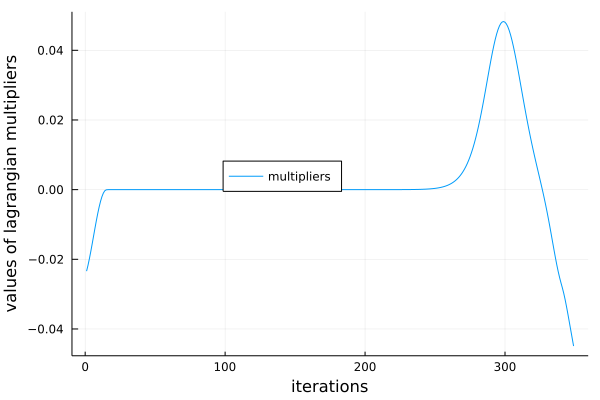

has_dual ? : true


In [29]:
#Lagrangian multipliers

print("has_dual ? : " , has_duals(sys2))
print("\n")
storage = zeros(N-1)
for i in 1 : N-1
    storage[i] = dual(p_t2[i])
end

lagrangian_multipliers = plot(storage,fmt=:png,xlabel = "iterations", ylabel = "values of lagrangian multipliers",legend = :inside, label = "multipliers")
display(plot(lagrangian_multipliers,layout=(1,1)))

Solving...
This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    14322
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    39088

Total number of variables............................:     2801
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      351
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2456
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr

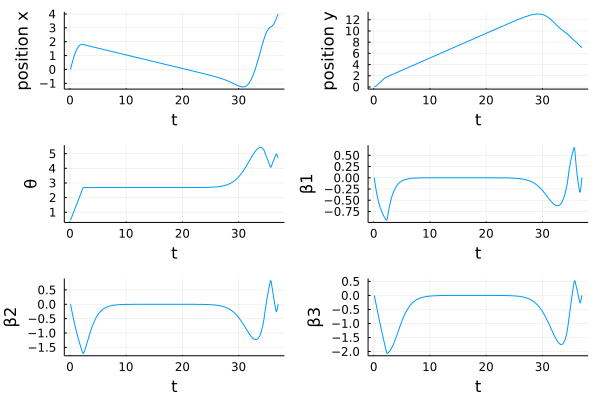

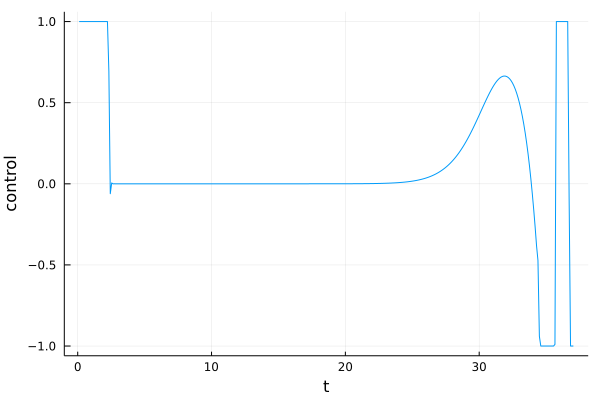


Cost : 0.10587965064412395
tf = 37.03668838766045


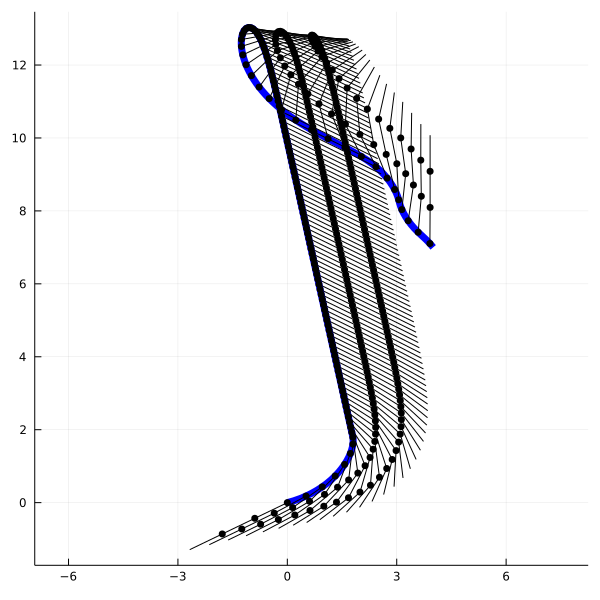

In [30]:
#JuMP model, Ipopt solver
sys3 = Model(optimizer_with_attributes(Ipopt.Optimizer,"print_level"=> 5))
set_optimizer_attribute(sys3,"tol",1e-14)
set_optimizer_attribute(sys3,"max_iter",1000)

#Parameters

# constants
w = 0.8
l = 0.99
epsi = 10^(-5)

# initial data
x0 = 0 
y0 = 0 
θ0 = pi/7
β1_0 = 0 
β2_0 = 0
β3_0 = 0
c0 = 0

# final data
xf = 4
yf = 7
θf = 3*pi/2 
β1_f = 0
β2_f = 0
β3_f = 0

N = 350
# Bounds for variables

JuMP.@variables(sys3,begin
    x[1:N]           # x 
    y[1:N]           # y 
    θ[1:N]           # theta
    β1[1:N]          # beta1 
    β2[1:N]          # beta2
    β3[1:N]          # beta3
    -1 ≤ u[1:N] ≤ 1  # u, control
     0 ≤ Δt ≤ 1  
    c[1:N]
    end)

# Objective
@objective(sys3,Min,Δt+epsi*c[N])

# Constraints 

@constraints(sys3,begin
    x[1] == x0
    y[1] == y0
    θ[1] == θ0
    β1[1]== β1_0
    β2[1] == β2_0
    β3[1] == β3_0
    c[1] == c0
    x[N] == xf
    y[N] == yf
    θ[N] == θf
    β1[N] == β1_f
    β2[N] == β2_f
    β3[N] == β3_f
        end)

# Dynamics : Crank-Nicolson scheme

for j in 1 : N-1
    @NLconstraint(sys3, # x' = w + cos(theta)
        x[j+1] == x[j] + 0.5 * Δt * (w + cos(θ[j]) + w + cos(θ[j+1])))
    @NLconstraint(sys3, # y' = sin(theta) 
        y[j+1] == y[j] + 0.5* Δt *(sin(θ[j])+ sin(θ[j+1])))
    @NLconstraint(sys3, #beta1 ' = -u- 1/l * sin(beta1)
        β1[j+1] == β1[j] + 0.5 * Δt * (-u[j]-(1/l)*sin(β1[j]) - u[j+1] - (1/l)*sin(β1[j+1])))
    @NLconstraint(sys3, #beta2' = -u - cos(beta1)*sin(beta2 - beta1)/l
        β2[j+1] == β2[j] + 0.5 *  Δt * (-u[j] - cos(β1[j])*sin(β2[j] - β1[j])/l - u[j+1] - cos(β1[j+1])*sin(β2[j+1] - β1[j+1])/l ))
    @NLconstraint(sys3, #beta3' = -u - cos(beta1) * cos(beta2-beta1)*sin(beta3 - beta2)
        β3[j+1] == β3[j] +0.5  * Δt * (-u[j] - cos(β1[j])*cos(β2[j] - β1[j]) * sin(β3[j] - β2[j])/l -u[j+1] - cos(β1[j+1])*cos(β2[j+1] - β1[j+1]) * sin(β3[j+1] - β2[j+1])/l ))
    @NLconstraint(sys3, # L2-norm regularization on the control
        c[j+1] == c[j] + 0.5 * Δt * (u[j]^2+ u[j+1]^2))
end

@NLconstraint(sys3,p_t3[j = 1:(N-1)],  # theta ' = u 
        θ[j+1] == θ[j] + 0.5 * Δt * (u[j] + u[j+1]) )

#Solve for the control and state
println("Solving...")
status = optimize!(sys3)
println("Solver status : ",status)
x1 = value.(x)
y1 = value.(y)
θ1 = value.(θ)
β_1 = value.(β1)
β_2 = value.(β2)
β_3 = value.(β3)
u1 = value.(u)
println("Cost : " , objective_value(sys3))

println("tf = ", value.(Δt)*N)


#plots : states 

Δt1 = value.(Δt)
t = (1 : N)*Δt1
#h = (1 : N)

x_plot = plot(t,x1,xlabel = "t", ylabel = "position x", legend = false, fmt = :png)
y_plot = plot(t,y1,xlabel = "t", ylabel = "position y", legend = false, fmt = :png)
θ_plot = plot(t,θ1,xlabel = "t", ylabel = "θ", legend = false, fmt = :png)
β1_plot = plot(t,β_1,xlabel = "t", ylabel = "β1", legend = false, fmt = :png)
β2_plot = plot(t,β_2,xlabel = "t", ylabel = "β2", legend = false, fmt = :png)
β3_plot = plot(t,β_3,xlabel = "t", ylabel = "β3", legend = false, fmt = :png)
display(plot(x_plot,y_plot,θ_plot,β1_plot,β2_plot,β3_plot ,layout = (3,2)))
u_plot = plot(t,u1,xlabel = "t", ylabel = "control", legend = false, fmt = :png)
display(u_plot)


#plots : trajectory 

p = plot(x1,y1, c = :blue, lw = 7)
plot!(size=(2000,2000))

for i = 1:dN:N 
    z = [x1[i] y1[i]]
    θ_p = θ1[i]
    β1_p = β_1[i]
    β2_p = β_2[i]
    β3_p = β_3[i]
    θ_1 =  β1_p + θ_p
    θ_2 =  β2_p + θ_p
    θ_3 =  β3_p + θ_p
    z1 = z - l*[cos(θ_1) sin(θ_1)]
    z2 = z1 - l*[cos(θ_2) sin(θ_2)]
    z3 = z2 - l*[cos(θ_3) sin(θ_3)]
    plot!([z[1],z1[1]], [z[2],z1[2]] ,color=:black, legend = false)
    plot!([z1[1],z2[1]], [z1[2],z2[2]], color=:black, legend = false)
    plot!([z2[1],z3[1]], [z2[2],z3[2]], color=:black, legend = false)
    plot!([z[1]],[z[2]],seriestype = :scatter, color =:black , legend = false)
    plot!([z1[1]],[z1[2]],seriestype = :scatter, color =:black , legend = false) 
    plot!([z2[1]],[z2[2]],seriestype = :scatter, color =:black , legend = false) 
    plot!(size=(600,600), aspect_ratio=:equal)
end
current()

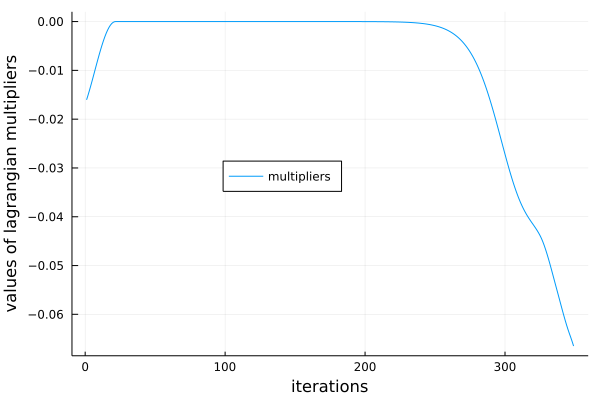

has_dual ? : true


In [31]:
#Lagrangian multipliers

print("has_dual ? : " , has_duals(sys3))
print("\n")
storage = zeros(N-1)
for i in 1 : N-1
    storage[i] = dual(p_t3[i])
end

lagrangian_multipliers = plot(storage,fmt=:png,xlabel = "iterations", ylabel = "values of lagrangian multipliers",legend = :inside, label = "multipliers")
display(plot(lagrangian_multipliers,layout=(1,1)))